**WARNING**: Remember to run the `ExtractBoundaries` notebook present in this same folder before running all (or specifically the `Import Boundaries` cell)

In [23]:
SAVE_ON_DRIVE = True
TYPE = 'Train'
STYLE_TRANSFER = False

# Dataset initialization


### Download Data

In [24]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')
if (os.path.exists("./Train") == False):
    if (os.path.exists("/content/drive/MyDrive/LoveDA/Train.zip")):
        print("Dataset available on own drive, unzipping...")
        !unzip -q /content/drive/MyDrive/LoveDA/Train.zip -d ./
    else:
        print("Downloading dataset...")
        !wget -O Train.zip "https://zenodo.org/records/5706578/files/Train.zip?download=1"
        if(SAVE_ON_DRIVE):
            print("Saving dataset on drive...")
            !cp Train.zip /content/drive/MyDrive/LoveDA/
        !unzip -q Train.zip -d ./

else:
    print("Dataset already in local")


if STYLE_TRANSFER:
  if (os.path.exists("./StyleTransfer") == False):
    if (os.path.exists("/content/drive/MyDrive/LoveDA/StyleTransfer.zip")):
      print("StyleTransfer available on own drive, unzipping...")
      !mkdir ./StyleTransfer
      !unzip -q /content/drive/MyDrive/LoveDA/StyleTransfer.zip -d ./StyleTransfer
    else:
      print("Cant download StyleTransfer")
  else:
    print("StyleTransfer already in local")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already in local


### Import Boundaries

In [25]:
# Paths
rural_boundaries_path = "./Train/Rural/boundaries_png"
rural_masks_path = './Train/Rural/masks_png'

urban_boundaries_path = "./Train/Urban/boundaries_png"
urban_masks_path = './Train/Urban/masks_png'
drive_rural_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Rural/boundaries_png'
drive_urban_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Urban/boundaries_png'

boundaries_paths = [rural_boundaries_path, urban_boundaries_path]

# Make dir inside ./Train/...
for boundaries_path in boundaries_paths:
    if (os.path.exists(boundaries_path) == False):
        print(f"Creating {boundaries_path}...")
        os.makedirs(boundaries_path)
    else:
        print(f"{boundaries_path} exists...")


# Check if files are already present
rural_file_count = len([name for name in os.listdir(rural_boundaries_path) if os.path.isfile(os.path.join(rural_boundaries_path, name))])
rural_mask_file_count = len([name for name in os.listdir(rural_masks_path) if os.path.isfile(os.path.join(rural_masks_path, name))])
urban_file_count = len([name for name in os.listdir(urban_boundaries_path) if os.path.isfile(os.path.join(urban_boundaries_path, name))])
urban_mask_file_count = len([name for name in os.listdir(urban_masks_path) if os.path.isfile(os.path.join(urban_masks_path, name))])

if (rural_file_count != rural_mask_file_count):
    print(f"Importing boundaries, as we have {rural_file_count} rural boundaries as of now...")
    shutil.copytree(drive_rural_boundaries_path, rural_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Rural boundaries already present, {rural_file_count} files...")

if (urban_file_count != urban_mask_file_count):
    print(f"Importing boundaries, as we have {urban_file_count} urban boundaries as of now...")
    shutil.copytree(drive_urban_boundaries_path, urban_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Urban boundaries already present, {urban_file_count} files...")

./Train/Rural/boundaries_png exists...
./Train/Urban/boundaries_png exists...
Rural boundaries already present, 1366 files...
Urban boundaries already present, 1156 files...


### Dataset Definition

In [26]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random
import cv2


def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, baseTransform, augTransforms, split = 'Urban', typeDataset = 'Train', useBoundaries=True, styleTransfer = True, probStyle=0.0, validation_ratio=0.2, seed=265637):
        # Validate type input
        if typeDataset not in ['Train', 'Validation', 'Total', 'ActualTest']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest'.")
        self.directory = []
        if typeDataset == 'ActualTest':
            directory_path = os.path.join('./Val', split, 'images_png')
        else:
            directory_path = os.path.join('./Train', split, 'images_png')
        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")
        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]
        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)
        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if typeDataset == 'Train':
          self.directory = all_images[:split_idx]
          if styleTransfer:
            style_directory = []
            listFromStyleToOriginal = []
            # Remove ones that not exist in directory, we have StyleTransfer Only in train
            for el in self.directory:
              name = el.replace('Train/Urban/images_png', 'StyleTransfer/Urban')
              style_directory.append(name)
              listFromStyleToOriginal.append(el)
            self.style_directory = style_directory
            self.probStyle = probStyle
            self.listFromStyleToOriginal = listFromStyleToOriginal
        elif typeDataset == 'Validation':
            self.directory = all_images[split_idx:]
        elif typeDataset == 'Total':
            self.directory = all_images
        elif typeDataset == 'ActualTest':
            self.directory = all_images
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest.")
        self.baseTransforms = baseTransform
        self.augTransforms = augTransforms
        self.useBoundaries = useBoundaries
        self.typeDataset = typeDataset
        self.styleTransfer = styleTransfer
        self.probStyle = probStyle
        # Print dataset size
        print(f"Dataset size: {len(self.directory)}")

    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
      image_path = self.directory[idx]
      image = pil_loader(image_path, 'RGB')
      mask_path = image_path.replace('images_png', 'masks_png')
      boundaries_path = image_path.replace('images_png', 'boundaries_png')

      mask = pil_loader(mask_path, 'L')

      if self.useBoundaries:
        boundaries = pil_loader(boundaries_path, 'L')
      else:
        boundaries = mask

      base_transformed = self.baseTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
      base_image = base_transformed['image']
      base_mask = base_transformed['mask']
      base_boundaries = base_transformed['boundaries']

      base_image = T.Compose([T.ToTensor()])(base_image)
      base_mask = torch.from_numpy(base_mask).long()
      base_mask -= 1
      base_boundaries = torch.from_numpy(base_boundaries)

      if(self.typeDataset != 'Train'):
        return base_image, base_mask, image_path, base_boundaries

      return base_image, base_mask, image_path, base_boundaries

### Dataset Utils

In [27]:
from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



In [28]:
# # Comment this cell to save GPU time

# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.patches as mpatches

# train_dataset = LoveDADataset(type='Train', seed=222)
# print(train_dataset.__len__())

# # Get item
# image, mask, path, bd = train_dataset.__getitem__(88)

# # Show path
# print(f"Image is at {path}")

# # Show image
# image = image.permute(1, 2, 0)
# image = image.numpy()
# plt.imshow(image)

# # Show mask
# new_image = new_colors_mask(mask)
# plt.imshow(image)
# plt.show()
# plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.imshow(new_image)
# plt.show()

# # Show boundaries
# # for row in bd:
# #     for col in row:
# #         if col != 0 and col != 1:
# #             print(col)
# bd = bd.numpy()
# plt.imshow(bd)


# Initialize model

### STDC Net

In [29]:
import torch
import torch.nn as nn
from torch.nn import init
import math



class ConvX(nn.Module):
    def __init__(self, in_planes, out_planes, kernel=3, stride=1):
        super(ConvX, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel, stride=stride, padding=kernel//2, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


class AddBottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, block_num=3, stride=1):
        super(AddBottleneck, self).__init__()
        assert block_num > 1, print("block number should be larger than 1.")
        self.conv_list = nn.ModuleList()
        self.stride = stride
        if stride == 2:
            self.avd_layer = nn.Sequential(
                nn.Conv2d(out_planes//2, out_planes//2, kernel_size=3, stride=2, padding=1, groups=out_planes//2, bias=False),
                nn.BatchNorm2d(out_planes//2),
            )
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=2, padding=1, groups=in_planes, bias=False),
                nn.BatchNorm2d(in_planes),
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes),
            )
            stride = 1

        for idx in range(block_num):
            if idx == 0:
                self.conv_list.append(ConvX(in_planes, out_planes//2, kernel=1))
            elif idx == 1 and block_num == 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//2, stride=stride))
            elif idx == 1 and block_num > 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//4, stride=stride))
            elif idx < block_num - 1:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx+1))))
            else:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx))))

    def forward(self, x):
        out_list = []
        out = x

        for idx, conv in enumerate(self.conv_list):
            if idx == 0 and self.stride == 2:
                out = self.avd_layer(conv(out))
            else:
                out = conv(out)
            out_list.append(out)

        if self.stride == 2:
            x = self.skip(x)

        return torch.cat(out_list, dim=1) + x



class CatBottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, block_num=3, stride=1):
        super(CatBottleneck, self).__init__()
        assert block_num > 1, print("block number should be larger than 1.")
        self.conv_list = nn.ModuleList()
        self.stride = stride
        if stride == 2:
            self.avd_layer = nn.Sequential(
                nn.Conv2d(out_planes//2, out_planes//2, kernel_size=3, stride=2, padding=1, groups=out_planes//2, bias=False),
                nn.BatchNorm2d(out_planes//2),
            )
            self.skip = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            stride = 1

        for idx in range(block_num):
            if idx == 0:
                self.conv_list.append(ConvX(in_planes, out_planes//2, kernel=1))
            elif idx == 1 and block_num == 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//2, stride=stride))
            elif idx == 1 and block_num > 2:
                self.conv_list.append(ConvX(out_planes//2, out_planes//4, stride=stride))
            elif idx < block_num - 1:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx+1))))
            else:
                self.conv_list.append(ConvX(out_planes//int(math.pow(2, idx)), out_planes//int(math.pow(2, idx))))

    def forward(self, x):
        out_list = []
        out1 = self.conv_list[0](x)

        for idx, conv in enumerate(self.conv_list[1:]):
            if idx == 0:
                if self.stride == 2:
                    out = conv(self.avd_layer(out1))
                else:
                    out = conv(out1)
            else:
                out = conv(out)
            out_list.append(out)

        if self.stride == 2:
            out1 = self.skip(out1)
        out_list.insert(0, out1)

        out = torch.cat(out_list, dim=1)
        return out

#STDC2Net
class STDCNet1446(nn.Module):
    def __init__(self, base=64, layers=[4,5,3], block_num=4, type="cat", num_classes=1000, dropout=0.20, pretrain_model='', use_conv_last=False):
        super(STDCNet1446, self).__init__()
        if type == "cat":
            block = CatBottleneck
        elif type == "add":
            block = AddBottleneck
        self.use_conv_last = use_conv_last
        self.features = self._make_layers(base, layers, block_num, block)
        self.conv_last = ConvX(base*16, max(1024, base*16), 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(max(1024, base*16), max(1024, base*16), bias=False)
        self.bn = nn.BatchNorm1d(max(1024, base*16))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(max(1024, base*16), num_classes, bias=False)

        self.x2 = nn.Sequential(self.features[:1])
        self.x4 = nn.Sequential(self.features[1:2])
        self.x8 = nn.Sequential(self.features[2:6])
        self.x16 = nn.Sequential(self.features[6:11])
        self.x32 = nn.Sequential(self.features[11:])

        if pretrain_model:
            print('use pretrain model {}'.format(pretrain_model))
            self.init_weight(pretrain_model)
        else:
            self.init_params()

    def init_weight(self, pretrain_model):

        state_dict = torch.load(pretrain_model)["state_dict"]
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def _make_layers(self, base, layers, block_num, block):
        features = []
        features += [ConvX(3, base//2, 3, 2)]
        features += [ConvX(base//2, base, 3, 2)]

        for i, layer in enumerate(layers):
            for j in range(layer):
                if i == 0 and j == 0:
                    features.append(block(base, base*4, block_num, 2))
                elif j == 0:
                    features.append(block(base*int(math.pow(2,i+1)), base*int(math.pow(2,i+2)), block_num, 2))
                else:
                    features.append(block(base*int(math.pow(2,i+2)), base*int(math.pow(2,i+2)), block_num, 1))

        return nn.Sequential(*features)

    def forward(self, x):
        feat2 = self.x2(x)
        feat4 = self.x4(feat2)
        feat8 = self.x8(feat4)
        feat16 = self.x16(feat8)
        feat32 = self.x32(feat16)
        if self.use_conv_last:
           feat32 = self.conv_last(feat32)

        return feat2, feat4, feat8, feat16, feat32

    def forward_impl(self, x):
        out = self.features(x)
        out = self.conv_last(out).pow(2)
        out = self.gap(out).flatten(1)
        out = self.fc(out)
        # out = self.bn(out)
        out = self.relu(out)
        # out = self.relu(self.bn(self.fc(out)))
        out = self.dropout(out)
        out = self.linear(out)
        return out

# STDC1Net
class STDCNet813(nn.Module):
    def __init__(self, base=64, layers=[2,2,2], block_num=4, type="cat", num_classes=1000, dropout=0.20, pretrain_model='', use_conv_last=False):
        super(STDCNet813, self).__init__()
        if type == "cat":
            block = CatBottleneck
        elif type == "add":
            block = AddBottleneck
        self.use_conv_last = use_conv_last
        self.features = self._make_layers(base, layers, block_num, block)
        self.conv_last = ConvX(base*16, max(1024, base*16), 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(max(1024, base*16), max(1024, base*16), bias=False)
        self.bn = nn.BatchNorm1d(max(1024, base*16))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(max(1024, base*16), num_classes, bias=False)

        self.x2 = nn.Sequential(self.features[:1])
        self.x4 = nn.Sequential(self.features[1:2])
        self.x8 = nn.Sequential(self.features[2:4])
        self.x16 = nn.Sequential(self.features[4:6])
        self.x32 = nn.Sequential(self.features[6:])

        if pretrain_model:
            print('use pretrain model {}'.format(pretrain_model))
            self.init_weight(pretrain_model)
        else:
            self.init_params()

    def init_weight(self, pretrain_model):

        state_dict = torch.load(pretrain_model)["state_dict"]
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def _make_layers(self, base, layers, block_num, block):
        features = []
        features += [ConvX(3, base//2, 3, 2)]
        features += [ConvX(base//2, base, 3, 2)]

        for i, layer in enumerate(layers):
            for j in range(layer):
                if i == 0 and j == 0:
                    features.append(block(base, base*4, block_num, 2))
                elif j == 0:
                    features.append(block(base*int(math.pow(2,i+1)), base*int(math.pow(2,i+2)), block_num, 2))
                else:
                    features.append(block(base*int(math.pow(2,i+2)), base*int(math.pow(2,i+2)), block_num, 1))

        return nn.Sequential(*features)

    def forward(self, x):
        feat2 = self.x2(x)
        feat4 = self.x4(feat2)
        feat8 = self.x8(feat4)
        feat16 = self.x16(feat8)
        feat32 = self.x32(feat16)
        if self.use_conv_last:
           feat32 = self.conv_last(feat32)

        return feat2, feat4, feat8, feat16, feat32

    def forward_impl(self, x):
        out = self.features(x)
        out = self.conv_last(out).pow(2)
        out = self.gap(out).flatten(1)
        out = self.fc(out)
        # out = self.bn(out)
        out = self.relu(out)
        # out = self.relu(self.bn(self.fc(out)))
        out = self.dropout(out)
        out = self.linear(out)
        return out

### STDC Definition

In [30]:
#!/usr/bin/python
# -*- encoding: utf-8 -*-


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

BatchNorm2d = nn.BatchNorm2d

class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                out_chan,
                kernel_size = ks,
                stride = stride,
                padding = padding,
                bias = False)
        self.bn = BatchNorm2d(out_chan)
        #self.bn = BatchNorm2d(out_chan, activation='none')
        self.relu = nn.ReLU()
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(mid_chan, n_classes, kernel_size=1, bias=False)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(out_chan, out_chan, kernel_size= 1, bias=False)
        self.bn_atten = BatchNorm2d(out_chan)
        #self.bn_atten = BatchNorm2d(out_chan, activation='none')

        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class ContextPath(nn.Module):
    def __init__(self, backbone='CatNetSmall', pretrain_model='', use_conv_last=False, *args, **kwargs):
        super(ContextPath, self).__init__()

        self.backbone_name = backbone
        if backbone == 'STDCNet1446':
            self.backbone = STDCNet1446(pretrain_model=pretrain_model, use_conv_last=use_conv_last)
            self.arm16 = AttentionRefinementModule(512, 128)
            inplanes = 1024
            if use_conv_last:
                inplanes = 1024
            self.arm32 = AttentionRefinementModule(inplanes, 128)
            self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_avg = ConvBNReLU(inplanes, 128, ks=1, stride=1, padding=0)

        elif backbone == 'STDCNet813':
            self.backbone = STDCNet813(pretrain_model=pretrain_model, use_conv_last=use_conv_last)
            self.arm16 = AttentionRefinementModule(512, 128)
            inplanes = 1024
            if use_conv_last:
                inplanes = 1024
            self.arm32 = AttentionRefinementModule(inplanes, 128)
            self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
            self.conv_avg = ConvBNReLU(inplanes, 128, ks=1, stride=1, padding=0)
        else:
            print("backbone is not in backbone lists")
            exit(0)

        self.init_weight()

    def forward(self, x):
        H0, W0 = x.size()[2:]

        feat2, feat4, feat8, feat16, feat32 = self.backbone(x)
        H8, W8 = feat8.size()[2:]
        H16, W16 = feat16.size()[2:]
        H32, W32 = feat32.size()[2:]

        avg = F.avg_pool2d(feat32, feat32.size()[2:])

        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (H32, W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (H16, W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (H8, W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat2, feat4, feat8, feat16, feat16_up, feat32_up # x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                out_chan//4,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.conv2 = nn.Conv2d(out_chan//4,
                out_chan,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class BiSeNet(nn.Module):
    def __init__(self, backbone, n_classes, pretrain_model='', use_boundary_2=False, use_boundary_4=False, use_boundary_8=False, use_boundary_16=False, use_conv_last=False, heat_map=False, *args, **kwargs):
        super(BiSeNet, self).__init__()

        self.use_boundary_2 = use_boundary_2
        self.use_boundary_4 = use_boundary_4
        self.use_boundary_8 = use_boundary_8
        self.use_boundary_16 = use_boundary_16
        # self.heat_map = heat_map
        self.cp = ContextPath(backbone, pretrain_model, use_conv_last=use_conv_last)



        if backbone == 'STDCNet1446':
            conv_out_inplanes = 128
            sp2_inplanes = 32
            sp4_inplanes = 64
            sp8_inplanes = 256
            sp16_inplanes = 512
            inplane = sp8_inplanes + conv_out_inplanes

        elif backbone == 'STDCNet813':
            conv_out_inplanes = 128
            sp2_inplanes = 32
            sp4_inplanes = 64
            sp8_inplanes = 256
            sp16_inplanes = 512
            inplane = sp8_inplanes + conv_out_inplanes

        else:
            print("backbone is not in backbone lists")
            exit(0)

        self.ffm = FeatureFusionModule(inplane, 256)
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(conv_out_inplanes, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(conv_out_inplanes, 64, n_classes)

        self.conv_out_sp16 = BiSeNetOutput(sp16_inplanes, 64, 1)

        self.conv_out_sp8 = BiSeNetOutput(sp8_inplanes, 64, 1)
        self.conv_out_sp4 = BiSeNetOutput(sp4_inplanes, 64, 1)
        self.conv_out_sp2 = BiSeNetOutput(sp2_inplanes, 64, 1)
        self.init_weight()

    def forward(self, x):
        H, W = x.size()[2:]

        feat_res2, feat_res4, feat_res8, feat_res16, feat_cp8, feat_cp16 = self.cp(x)

        feat_out_sp2 = self.conv_out_sp2(feat_res2)

        feat_out_sp4 = self.conv_out_sp4(feat_res4)

        feat_out_sp8 = self.conv_out_sp8(feat_res8)

        feat_out_sp16 = self.conv_out_sp16(feat_res16)

        feat_fuse = self.ffm(feat_res8, feat_cp8)

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)
        feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)
        feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)


        if self.use_boundary_2 and self.use_boundary_4 and self.use_boundary_8:
            return feat_out, feat_out16, feat_out32, feat_out_sp2, feat_out_sp4, feat_out_sp8

        if (not self.use_boundary_2) and self.use_boundary_4 and self.use_boundary_8:
            return feat_out, feat_out16, feat_out32, feat_out_sp4, feat_out_sp8

        if (not self.use_boundary_2) and (not self.use_boundary_4) and self.use_boundary_8:
            return feat_out, feat_out16, feat_out32, feat_out_sp8

        if (not self.use_boundary_2) and (not self.use_boundary_4) and (not self.use_boundary_8):
            return feat_out, feat_out16, feat_out32

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, (FeatureFusionModule, BiSeNetOutput)):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params



### Load PIDNet Model

In [31]:
import gdown
import tarfile
import os

if (os.path.exists("./model_maxmIOU75.pth") == False):
  url = "https://drive.google.com/uc?id=17nPaTe9mCQ9OEb0VFz32eJVfWzvEPKGW"
  output = "./"
  gdown.download(url, output, quiet=False)
# Then keep as tar, as it's already the correct format to feed the model

# # Create a config object with required parameters
# class Config:
#     class MODEL:
#         NAME = 'pidnet_s'  # or 'pidnet_m' or 'pidnet_l'
#         PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
#     class DATASET:
#         NUM_CLASSES = len(LABEL_MAP)

# cfg = Config()
pretrain_path = ''


model = BiSeNet(backbone='STDCNet1446', n_classes=len(LABEL_MAP), pretrain_model=pretrain_path,
    use_boundary_2=True, use_boundary_4=True, use_boundary_8=True,
    use_boundary_16=False, use_conv_last=False)

# Load the checkpoint with map_location to ensure it loads on CPU
checkpoint = torch.load('./model_maxmIOU75.pth', map_location=torch.device('cpu'))
model_state_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}

# Overwrite entries in the existing state dict
model_state_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_state_dict)

print("Model loaded")

Model loaded


<ipython-input-31-e20eaad5c52b>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./model_maxmIOU75.pth', map_location=torch.device('cpu'))


# Training & Dataset creation

### Ablations and Macros

In [32]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

LR = 1e-3            # The initial Learning Rate -- I increased it using quadratic rule in relation with batch size
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 21      # How many epochs before decreasing learning rate (if using a step-down policy) -- Trying to keep a 2:3 ratio with NUM_EPOCHS
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5
NUM_CLASSES = len(LABEL_MAP)
BATCH_SIZE = 32

USE_NORMALIZE_ON_RURAL = False

In [33]:
#!pip install -U albumentations

### Setup, Create Datasets and DataLoaders. With annexed transforms.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomScale, RandomCrop, GaussNoise, ElasticTransform, Rotate, Resize, OneOf, Normalize, HistogramMatching, ColorJitter
from albumentations.pytorch import ToTensorV2
import cv2

#How big should be the image that we feed to the model?
RESIZE = 512
SMALL_RESIZE = 256 # Use 256 to compare with DeepLab
# DEFINE TRANSFORMATIONS HERE
# To Tensor is not needed since its performed inside the getitem

AUGMENTATIONS = {
    'Resize': Compose([
            Resize(512, 512),
    ], additional_targets={"boundaries": "mask"}),
    'Jitter+RotateFlip+Resize': Compose([
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            OneOf([
                HorizontalFlip(p=0.5),
                RandomRotate90(p=0.5),
            ], p=0.5),
            Resize(RESIZE, RESIZE),
    ], additional_targets={"boundaries": "mask"})
}

CHOOSE_TRANSFORM = 'Jitter+RotateFlip+Resize'
if USE_NORMALIZE_ON_RURAL:
    CHOOSE_TRANSFORM = 'NormalizeOnRural+Resize512'
VALIDATION_TRANSFORM = CHOOSE_TRANSFORM
AUGTRANSFORM = None

## Dataset and Loader
# Training Sets and Loaders
train_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=None ,split='Urban', typeDataset='Train', styleTransfer=STYLE_TRANSFER, probStyle=0.5, validation_ratio=0.2)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

# Validation Sets and Loaders

validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS['Resize'], augTransforms=None, split='Urban', typeDataset='Validation', validation_ratio=0.2)

validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)


Dataset size: 924
Dataset size: 232


### Losses

In [35]:
def weighted_bce(bd_pre, target):
    n, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

  # Dice Loss (used for boundary regions)
def dice_loss(pred, target):
    smooth = 1e-6
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + smooth) / (union + smooth)

def boundary_loss(bd_pre, bd_gt):
    loss = 20.0 * weighted_bce(bd_pre, bd_gt)
    return loss

# TODO EXTRA add weights=class_weights to nn.CrossEntropyLoss()
# TODO EXTRA use OHCE instead of basic one
def cross_entropy(score, target):
    compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

    # See paper for weights. In order of loss index: (0.4, 20, 1, 1) # But on cfg they set everything to 0.5
    balance_weights = [0.4, 1]
    sb_weights = 1

    # print(f"DEBUG: inside cross_entropy: len(score) = {len(score)}")

    if isinstance(score, list):  # Multi-scale outputs
        if len(balance_weights) != len(score):
            raise ValueError("lengths of prediction and target are not identical!")
        return sum([w * compute_ce_loss(s, target) for w, s in zip(balance_weights, score)])
    else:  # Single output
        return sb_weights * compute_ce_loss(score, target)


    #         if isinstance(score, list):  # Multi-scale outputs
    #     if len(balance_weights) != len(score):
    #         raise ValueError("lengths of prediction and target are not identical!")
    #     return sum([w * compute_ce_loss(x, target) for (w, x) in zip(balance_weights, score)])
    # else:  # Single output
    #     return sb_weights * compute_ce_loss(score[0], target)

# def cross_entropy(score, target):
#     # Compute CrossEntropy loss with ignore_index=-1 for pixels to ignore
#     compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

#     # Example balance weights, this can be adjusted based on the classes in the dataset
#     balance_weights = [0.4, 1]

#     # If there are multiple output scales, apply weighted loss for each scale
#     if isinstance(score, list):  # If score is a list of multiple outputs
#         assert len(balance_weights) == len(score), "Balance weights and number of outputs must match."
#         loss = sum([w * compute_ce_loss(s, target) for w, s in zip(balance_weights, score)])
#     else:  # Single output (e.g., no multi-scale)
#         loss = compute_ce_loss(score, target)

#     return loss

class DetailAggregateLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(DetailAggregateLoss, self).__init__()

        self.laplacian_kernel = torch.tensor(
            [-1, -1, -1, -1, 8, -1, -1, -1, -1],
            dtype=torch.float32).reshape(1, 1, 3, 3).requires_grad_(False).type(torch.cuda.FloatTensor)

        self.fuse_kernel = torch.nn.Parameter(torch.tensor([[6./10], [3./10], [1./10]],
            dtype=torch.float32).reshape(1, 3, 1, 1).type(torch.cuda.FloatTensor))

    def forward(self, boundary_logits, gtmasks):

        # boundary_logits = boundary_logits.unsqueeze(1)
        boundary_targets = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, padding=1)
        boundary_targets = boundary_targets.clamp(min=0)
        boundary_targets[boundary_targets > 0.1] = 1
        boundary_targets[boundary_targets <= 0.1] = 0

        boundary_targets_x2 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=2, padding=1)
        boundary_targets_x2 = boundary_targets_x2.clamp(min=0)

        boundary_targets_x4 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=4, padding=1)
        boundary_targets_x4 = boundary_targets_x4.clamp(min=0)

        boundary_targets_x8 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=8, padding=1)
        boundary_targets_x8 = boundary_targets_x8.clamp(min=0)

        boundary_targets_x8_up = F.interpolate(boundary_targets_x8, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x4_up = F.interpolate(boundary_targets_x4, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x2_up = F.interpolate(boundary_targets_x2, boundary_targets.shape[2:], mode='nearest')

        boundary_targets_x2_up[boundary_targets_x2_up > 0.1] = 1
        boundary_targets_x2_up[boundary_targets_x2_up <= 0.1] = 0


        boundary_targets_x4_up[boundary_targets_x4_up > 0.1] = 1
        boundary_targets_x4_up[boundary_targets_x4_up <= 0.1] = 0


        boundary_targets_x8_up[boundary_targets_x8_up > 0.1] = 1
        boundary_targets_x8_up[boundary_targets_x8_up <= 0.1] = 0

        boudary_targets_pyramids = torch.stack((boundary_targets, boundary_targets_x2_up, boundary_targets_x4_up), dim=1)

        boudary_targets_pyramids = boudary_targets_pyramids.squeeze(2)
        boudary_targets_pyramid = F.conv2d(boudary_targets_pyramids, self.fuse_kernel)

        boudary_targets_pyramid[boudary_targets_pyramid > 0.1] = 1
        boudary_targets_pyramid[boudary_targets_pyramid <= 0.1] = 0


        if boundary_logits.shape[-1] != boundary_targets.shape[-1]:
            boundary_logits = F.interpolate(
                boundary_logits, boundary_targets.shape[2:], mode='bilinear', align_corners=True)

        bce_loss = F.binary_cross_entropy_with_logits(boundary_logits, boudary_targets_pyramid)
        dice_loss_value = dice_loss(torch.sigmoid(boundary_logits), boudary_targets_pyramid)
        return bce_loss,  dice_loss_value

sem_loss = cross_entropy
bd_loss = boundary_loss

### Training Loop

DEVICE is cuda
Starting epoch 1/20, LR = [0.001]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Loss at batch 0: 11.420489311218262
Loss at batch 5: 11.026652336120605
Loss at batch 10: 10.554645538330078
Loss at batch 15: 9.793071746826172
Loss at batch 20: 9.375669479370117
Loss at batch 25: 8.853960037231445
Epoch 1, Loss 67.832350730896
model succesfully saved on drive. loss went down to 67.832350730896
[EPOCH 1] Avg. Loss: 0.313159924532686


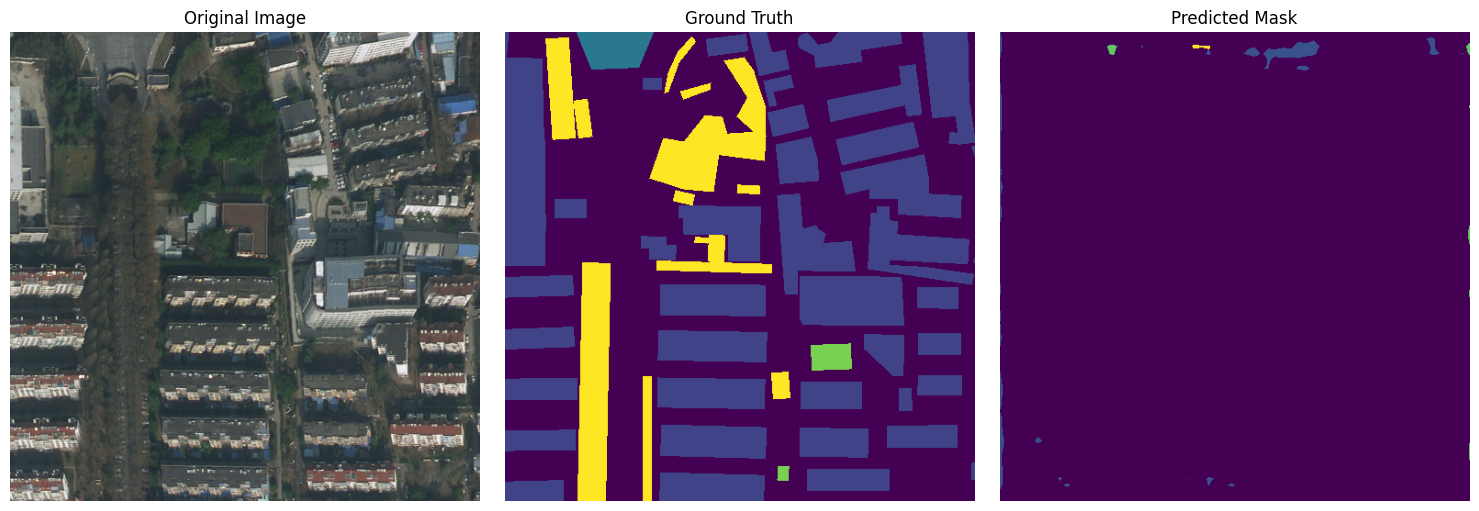

Starting epoch 2/20, LR = [0.001]
Loss at batch 0: 8.710865020751953
Loss at batch 5: 8.201430320739746
Loss at batch 10: 8.23901653289795
Loss at batch 15: 8.072257995605469
Loss at batch 20: 7.784210205078125
Loss at batch 25: 7.52952766418457
Epoch 2, Loss 57.38951587677002
model succesfully saved on drive. loss went down to 57.38951587677002
[EPOCH 2] Avg. Loss: 0.2534173476908888


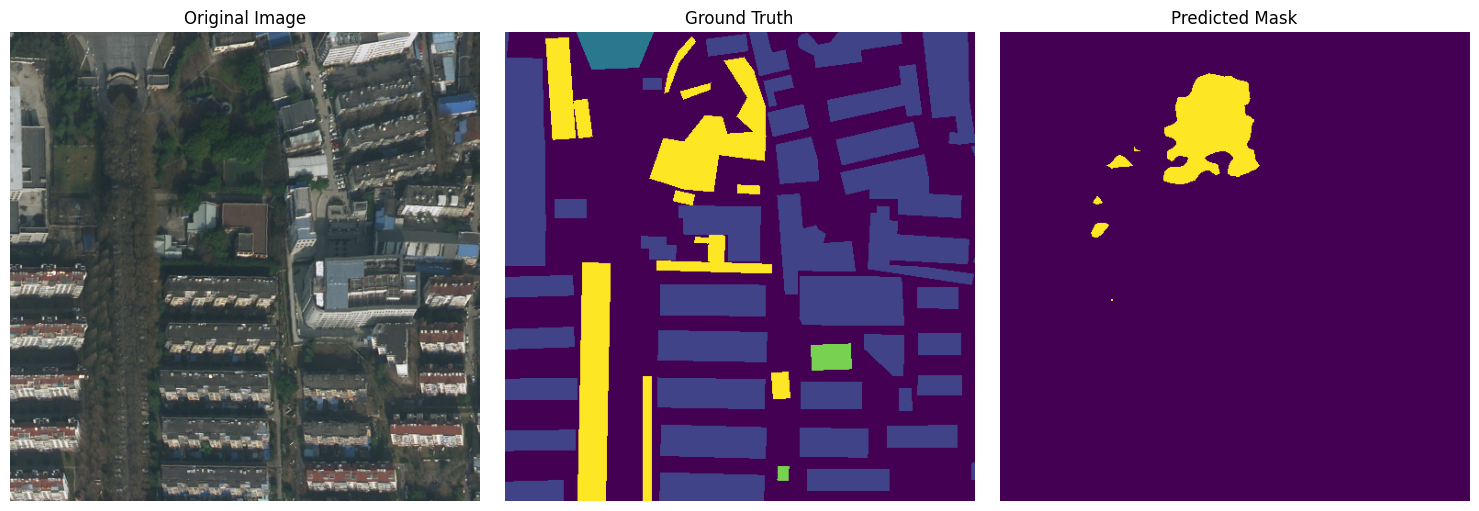

Starting epoch 3/20, LR = [0.001]
Loss at batch 0: 7.923641681671143
Loss at batch 5: 7.5625410079956055
Loss at batch 10: 7.566311836242676
Loss at batch 15: 7.71238899230957
Loss at batch 20: 7.693836688995361
Loss at batch 25: 7.657859802246094
Epoch 3, Loss 51.366427421569824
model succesfully saved on drive. loss went down to 51.366427421569824
[EPOCH 3] Avg. Loss: 0.23599752145154135


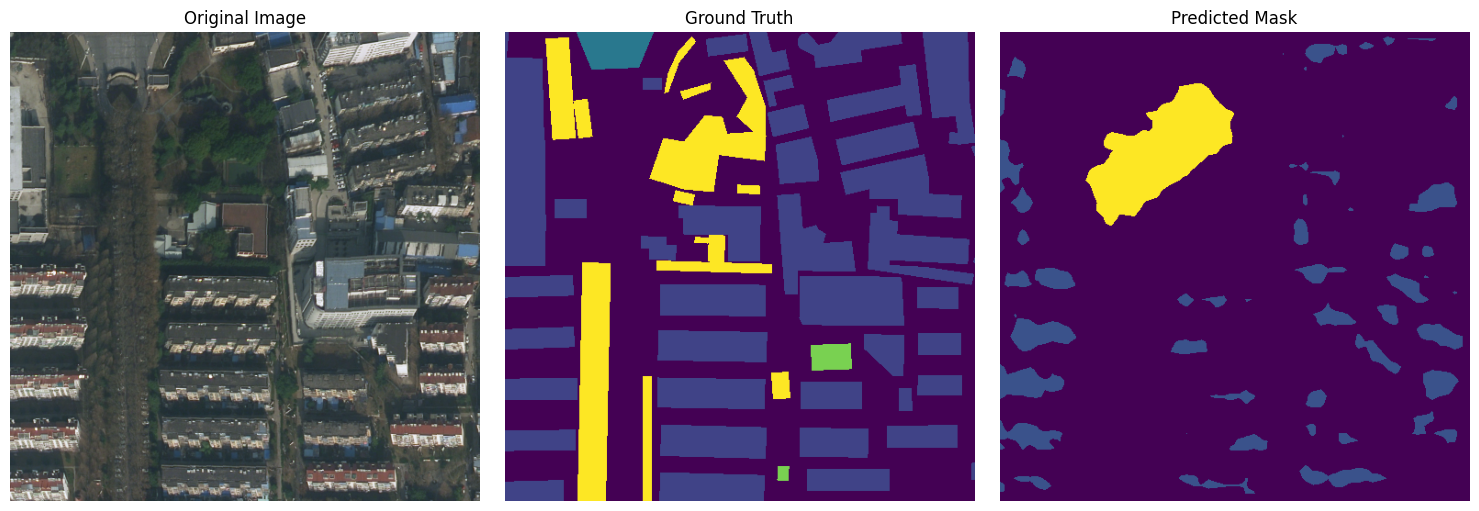

Starting epoch 4/20, LR = [0.001]
Loss at batch 0: 7.361408710479736
Loss at batch 5: 7.460491180419922
Loss at batch 10: 7.380883693695068
Loss at batch 15: 7.349916458129883
Loss at batch 20: 7.263978958129883
Loss at batch 25: 7.422687530517578
Epoch 4, Loss 49.77130842208862
model succesfully saved on drive. loss went down to 49.77130842208862
[EPOCH 4] Avg. Loss: 0.22836516531450407


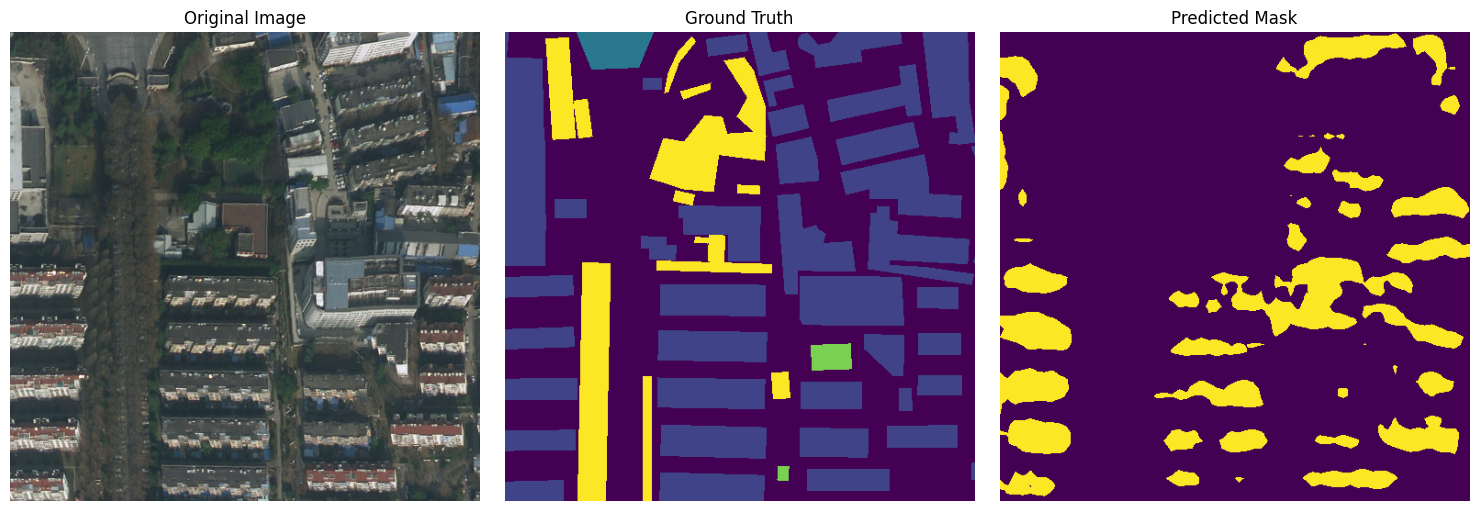

Starting epoch 5/20, LR = [0.001]
Loss at batch 0: 7.055988311767578
Loss at batch 5: 7.403952598571777
Loss at batch 10: 6.925645351409912
Loss at batch 15: 6.874998092651367
Loss at batch 20: 7.33110237121582
Loss at batch 25: 7.2608442306518555
Epoch 5, Loss 49.555428981781006
model succesfully saved on drive. loss went down to 49.555428981781006
[EPOCH 5] Avg. Loss: 0.2237409417118345


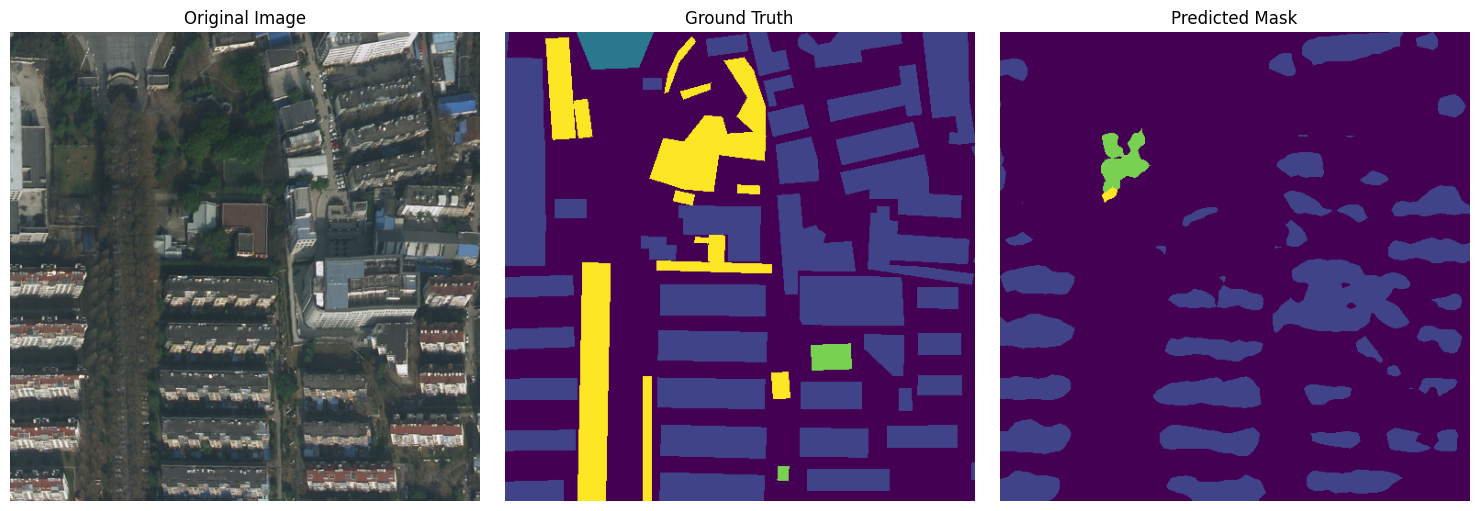

Starting epoch 6/20, LR = [0.001]
Loss at batch 0: 7.0386810302734375
Loss at batch 5: 7.068109035491943
Loss at batch 10: 7.149369239807129
Loss at batch 15: 7.443935394287109
Loss at batch 20: 7.185226917266846
Loss at batch 25: 7.105315208435059


In [ ]:
import matplotlib.pyplot as plt

# For easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

style_transf = ''
if STYLE_TRANSFER:
  style_transf = '_styleTransfer'

SAVE_MODEL_AS = f'best_model_STDC_{CHOOSE_TRANSFORM}_ST.pth'

current_step = 0

best_loss = float('inf')
best_model = model.state_dict()

use_boundary_2 = True
use_boundary_4 = True
use_boundary_8 = True

## Optimizier and Scheduler
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

model = model.to(DEVICE)
print(f"DEVICE is {DEVICE}")
if TYPE == 'Train':
  for epoch in range(NUM_EPOCHS):
    model.train()
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    epoch_loss = [0.0, 0]
    for (batch_i, batch) in enumerate(train_loader):
        optimizer.zero_grad()

        ### Extract input
        images, masks, img_path, bd_gts = batch
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        bd_gts = bd_gts.float().to(DEVICE)


        ### ===> Forward, Upscale, Compute Losses
        ## Forward
        outputs = model(images) # in model.train() mode batch size must be > 1 I think

        if use_boundary_2 and use_boundary_4 and use_boundary_8:
            out, out16, out32, detail2, detail4, detail8 = outputs

        if (not use_boundary_2) and use_boundary_4 and use_boundary_8:
            out, out16, out32, detail4, detail8 = outputs

        if (not use_boundary_2) and (not use_boundary_4) and use_boundary_8:
            out, out16, out32, detail8 = outputs

        if (not use_boundary_2) and (not use_boundary_4) and (not use_boundary_8):
            out, out16, out32 = outputs


        # Compute boundary loss
        boundary_loss_func = DetailAggregateLoss().to(DEVICE)
        boundary_bce_loss = 0.
        boundary_dice_loss = 0.


        if use_boundary_2:
            boundary_bce_loss2, boundary_dice_loss2 = boundary_loss_func(detail2, masks)
            boundary_bce_loss += boundary_bce_loss2
            boundary_dice_loss += boundary_dice_loss2

        if use_boundary_4:
            boundary_bce_loss4, boundary_dice_loss4 = boundary_loss_func(detail4, masks)
            boundary_bce_loss += boundary_bce_loss4
            boundary_dice_loss += boundary_dice_loss4

        if use_boundary_8:
            boundary_bce_loss8, boundary_dice_loss8 = boundary_loss_func(detail8, masks)
            boundary_bce_loss += boundary_bce_loss8
            boundary_dice_loss += boundary_dice_loss8

        ## Losses
        # Semantic Losses
        loss_s = sem_loss(out, masks)
        loss_2 = sem_loss(out16, masks)
        loss_3 = sem_loss(out32, masks)


        # Complete Loss
        total_loss = loss_s + loss_2 + loss_3 + boundary_bce_loss + boundary_dice_loss

        ### Backprop
        if batch_i % LOG_FREQUENCY == 0:
            print(f'Loss at batch {batch_i}: {total_loss.item()}')
        total_loss.backward()

        optimizer.step()
        epoch_loss[0] += total_loss.item()
        epoch_loss[1] += images.size(0)


    # Evaluate model on the evaluation set and save the parameters if is better than best model
    model.eval()
    total_loss = 0.0
    outputs = []
    with torch.no_grad():
      for (batch_i, batch) in enumerate(validation_loader):
        ### Extract input
        images, masks, img_path, bd_gts = batch
        images = images.float().to(DEVICE)
        masks = masks.to(DEVICE)
        bd_gts = bd_gts.float().to(DEVICE)

        ### ===> Forward, Upscale, Compute Losses
        ## Forward
        outputs = model(images)

        if use_boundary_2 and use_boundary_4 and use_boundary_8:
            out, out16, out32, detail2, detail4, detail8 = outputs

        if (not use_boundary_2) and use_boundary_4 and use_boundary_8:
            out, out16, out32, detail4, detail8 = outputs

        if (not use_boundary_2) and (not use_boundary_4) and use_boundary_8:
            out, out16, out32, detail8 = outputs

        if (not use_boundary_2) and (not use_boundary_4) and (not use_boundary_8):
            out, out16, out32 = outputs

        # ## Upscale (bilinear interpolation - not learned)
        # h, w = masks.size(1), masks.size(2)
        # ph, pw = outputs[0].size(2), outputs[0].size(3)
        # if ph != h or pw != w:
        #     for i in range(len(outputs)):
        #         outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        ## Losses
        # Compute boundary loss
        boundary_loss_func = DetailAggregateLoss().to(DEVICE)
        boundary_bce_loss = 0.
        boundary_dice_loss = 0.


        if use_boundary_2:
            boundary_bce_loss2, boundary_dice_loss2 = boundary_loss_func(detail2, masks)
            boundary_bce_loss += boundary_bce_loss2
            boundary_dice_loss += boundary_dice_loss2

        if use_boundary_4:
            boundary_bce_loss4, boundary_dice_loss4 = boundary_loss_func(detail4, masks)
            boundary_bce_loss += boundary_bce_loss4
            boundary_dice_loss += boundary_dice_loss4

        if use_boundary_8:
            boundary_bce_loss8, boundary_dice_loss8 = boundary_loss_func(detail8, masks)
            boundary_bce_loss += boundary_bce_loss8
            boundary_dice_loss += boundary_dice_loss8

        # Semantic Losses
        loss_s = sem_loss(out, masks)
        loss_2 = sem_loss(out16, masks)
        loss_3 = sem_loss(out32, masks)


        # Complete Loss
        loss = loss_s + loss_2 + loss_3 + boundary_bce_loss + boundary_dice_loss

        ### <=== Forward, Upscale, Compute Losses
        total_loss += loss.item()

    print('Epoch {}, Loss {}'.format(epoch+1, total_loss))
    if total_loss < best_loss:
      best_loss = total_loss
      best_model = model.state_dict()
      #Save in Drive and local
      torch.save(best_model, SAVE_MODEL_AS)
      if SAVE_ON_DRIVE:
        !cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
        print(f"model succesfully saved on drive. loss went down to {best_loss}")

    current_step += 1
    scheduler.step()
    print(f'[EPOCH {epoch+1}] Avg. Loss: {epoch_loss[0] / epoch_loss[1]}')

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(masks[0].cpu().numpy())
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()

In [ ]:
# from google.colab import runtime
# runtime.unassign()

## Try styleTransfer dataset


In [ ]:
# import matplotlib.pyplot as plt
# for i in range(10):
#   image, mask, path, boundaries = train_dataset.__getitem__(i)
#   image = image[0]
#   mask = mask[0]
#   boundaries = boundaries[0]
#   print(path)
#   # Draw image
#   plt.imshow(image.permute(1, 2, 0).cpu().numpy())
#   plt.show()
#   # Draw mask
#   plt.imshow(mask.cpu().numpy())
#   plt.show()
#   # Draw boundaries in greyscale
#   plt.imshow(boundaries.cpu().numpy(), cmap='gray')
#   plt.show()

# TEST

In [ ]:
#!pip install torchmetrics ptflops

In [ ]:

from tqdm import tqdm
import time

TYPE = 'Test'
# TARGET = 'Rural' # ALREADY RUNNING ON BOTH BELOW
#Load best_model
#!cp /content/drive/MyDrive/LoveDA/best_model_step2b.pth /content/best_model_step2b.pth



accuracy, mIoU = False, True

TARGETs = ['Urban', 'Rural']

for TARGET in TARGETs:
  if TARGET == 'Urban': # Here we just validate on less images (20%) if URBAN, as it's not the focus of step 3b.
      target_type = 'Validation'
  elif TARGET == 'Rural': # While we take the entirety of the Rural folder in case of Rural
      target_type = 'Total'
  else:
      raise ValueError("TARGET must be 'Urban' or 'Rural'")

  if CHOOSE_TRANSFORM == 'RandomCropOrResize':
    test_augmentation = AUGMENTATIONS['RandomCrop512']
  elif CHOOSE_TRANSFORM == 'RandomCropXXX':
    test_augmentation = AUGMENTATIONS['None']
  elif CHOOSE_TRANSFORM == 'Jitter':
    test_augmentation = AUGMENTATIONS['None']
  elif CHOOSE_TRANSFORM == 'GaussianBlur':
    test_augmentation = AUGMENTATIONS['None']
  else:
    test_augmentation = AUGMENTATIONS[CHOOSE_TRANSFORM]

  test_dataset = LoveDADataset(baseTranforms=test_augmentation, augTransforms=None, split=TARGET, type=target_type)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

  #### TEST LOOP
  model.eval()
  print(f"Testing on domain={TARGET} using augmentations={CHOOSE_TRANSFORM} on a {target_type} split")

  # Latency
  with torch.no_grad():
      start_time = time.time()
      for _ in range(100):
          _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
      end_time = time.time()
  latency = (end_time - start_time) / 100
  print(f"Latency: {latency:.4f} seconds")

  # FLOPs
  macs, _ = ptflops.get_model_complexity_info(model,
    (3, RESIZE, RESIZE), as_strings=False,
    print_per_layer_stat=False, verbose=False)
  flops = macs * 2  # MACs perform two FLOPs
  print("FLOPs:", flops)

  # Number of parameters
  total_params = sum(p.numel() for p in model.parameters())
  print(f"Total number of parameters: {total_params}")

  if TYPE == 'Test':
    with torch.no_grad():
        total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
        total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
        meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
        for (batch) in tqdm(test_loader):
            ### Extract input
            images, masks, img_path, bd_gts = batch
            images = images.float().to(DEVICE)
            masks = masks.to(DEVICE)

            ### ===> Forward, Upscale, Compute Losses
            ## Forward
            outputs = model(images)

            ## Upscale (bilinear interpolation - not learned)
            h, w = masks.size(1), masks.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
                for i in range(len(outputs)):
                    outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

            # Output 1 is the prediction

            # Shape: NBATCHES x classes x h x w
            class_indices = torch.argmax(outputs[1], dim=1)  # Shape: NBATCHES x h x w

            if accuracy:
            # Create a mask for valid targets (where target is not -1)
              valid_mask = (masks != -1)  # Mask of shape: NBATCHES x h x w
              # Apply the mask to ignore -1 targets when updating the accuracy metric
              meter.update(class_indices[valid_mask], masks[valid_mask])

            if mIoU:
              for predicted, target in zip(class_indices, masks):
                for i in range(NUM_CLASSES):
                  total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                  total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

    if accuracy:
      accuracy = meter.compute()
      print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

    if mIoU:
      intersection_over_union = total_intersection / total_union

      # Per class IoU
      for i, iou in enumerate(intersection_over_union):
          class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(i)]  # Get the class name from LABEL_MAP
          print(f'{class_name} IoU: {iou:.4f}')

      mIoU = torch.mean(intersection_over_union)
      print(f'\nmIoU on the target domain: {mIoU}')

  print("========================================================================")
